In [1]:
import warnings
import numpy as np
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import pmdarima as pmd
import math
from sklearn.metrics import mean_squared_error

In [2]:
# import data
df = pd.read_csv(r'D:/Dataset/oil_consumption.csv')

print(df)
print(df.dtypes)
print('\nTotal NaN Data:\n', df.isnull().sum())

    year           gdp  oil_energy_use
0   1960  3.010000e+11          250.00
1   1961  3.010000e+11          252.57
2   1962  3.010000e+11          259.76
3   1963  3.010000e+11          265.47
4   1964  3.010000e+11          267.09
..   ...           ...             ...
56  2016  9.320000e+11          903.97
57  2017  1.020000e+12          917.69
58  2018  1.040000e+12          936.89
59  2019  1.120000e+12          940.04
60  2020  1.060000e+12          967.33

[61 rows x 3 columns]
year                int64
gdp               float64
oil_energy_use    float64
dtype: object

Total NaN Data:
 year              0
gdp               0
oil_energy_use    0
dtype: int64


In [3]:
# checking the data correlation
df.corr()

,year,gdp,oil_energy_use
year,1.000000,0.721017,0.982418
gdp,0.721017,1.000000,0.756873
oil_energy_use,0.982418,0.756873,1.000000


In [4]:
#drop the gdp column since it has the least correlation
energy = df.drop('gdp', axis = 1)

print(energy)

    year  oil_energy_use
0   1960          250.00
1   1961          252.57
2   1962          259.76
3   1963          265.47
4   1964          267.09
..   ...             ...
56  2016          903.97
57  2017          917.69
58  2018          936.89
59  2019          940.04
60  2020          967.33

[61 rows x 2 columns]


In [5]:
# split data into training and testing
train = energy.loc[:51]
test = energy.loc[51:]

print(train.shape)
print(test.shape)

(52, 2)
(10, 2)


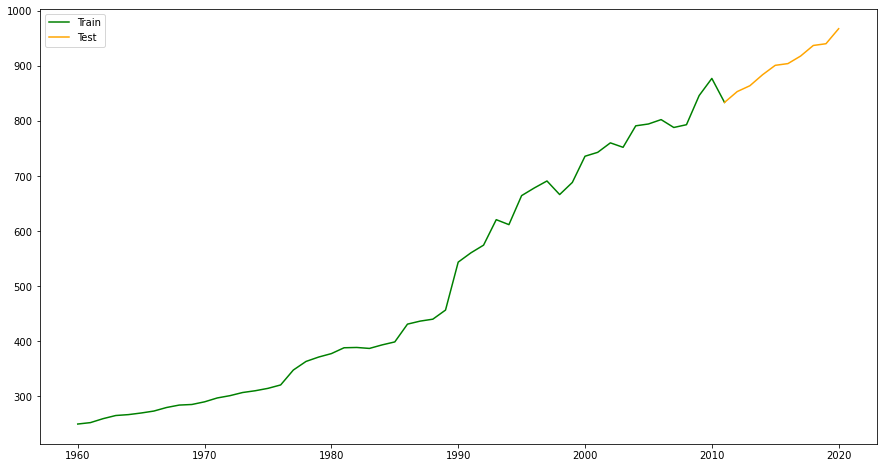

In [6]:
# plot dataset
train_x = train['year']
train_y = train['oil_energy_use']
test_x = test['year']
test_y = test['oil_energy_use']

plt.figure(figsize = (15, 8))
plt.plot(train_x, train_y, 'green',
         test_x, test_y, 'orange')
plt.legend(['Train', 'Test'])
plt.show()

In [20]:
# melihat stationarity data dengan ADF
# define function for ADF test
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(energy['oil_energy_use'])

Results of Dickey-Fuller Test:
Test Statistic                  0.761593
p-value                         0.990990
#Lags Used                      0.000000
Number of Observations Used    60.000000
Critical Value (1%)            -3.544369
Critical Value (5%)            -2.911073
Critical Value (10%)           -2.593190
dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                 -2.898846
p-value                         0.045482
#Lags Used                      2.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


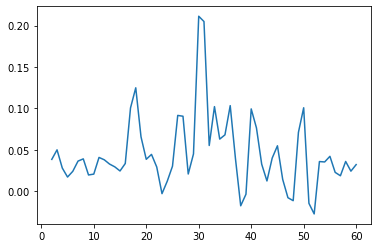

In [23]:
# shift log transformation
energy['oil_log'] = np.log(energy['oil_energy_use'])
energy['oil_log_diff'] = energy['oil_log'] - energy['oil_log'].shift(2)
energy['oil_log_diff'].dropna().plot()

logdif = energy['oil_log_diff']
adf_test(logdif.dropna())

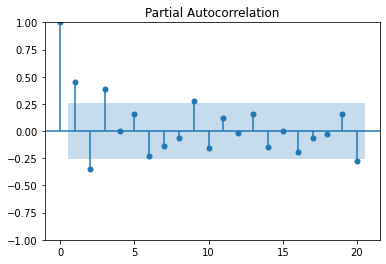

array([ 1.        ,  0.4593127 , -0.36732877,  0.4149909 , -0.01701872,
        0.18291323, -0.28343861, -0.13825179, -0.08013039,  0.36865879,
       -0.25882213,  0.23981605, -0.14754765,  0.39400026, -0.57153159,
        0.80926099, -5.81352035, -1.13223717])

In [9]:
# mencari nilai AR (p) dengan plot PACF
plot_pacf(logdif.dropna(), lags = 20, method = 'ywm')
plt.show()

sm.tsa.pacf(logdif.dropna())

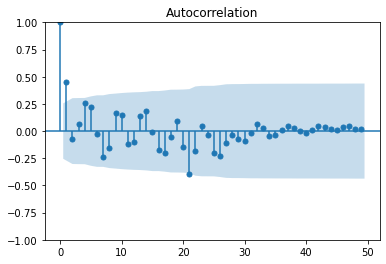

array([ 1.        ,  0.45152774, -0.07619252,  0.06170461,  0.26218926,
        0.22122352, -0.02977221, -0.23873802, -0.15793556,  0.16303228,
        0.14450509, -0.12139598, -0.09834513,  0.13996434,  0.18540654,
       -0.00731041, -0.17237895, -0.20561477])

In [10]:
# mencari nilai MA (q) dengan plot ACF
plot_acf(logdif.dropna(), lags = 49)
plt.show()

sm.tsa.acf(logdif.dropna())

In [11]:
# build the arima estimator
def arimamodel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              start_p = 1, 
                              start_q = 0,
                              test = "adf",
                              seasonal = False,
                              trace = True)
    return autoarima_model

In [12]:
arima_model = arimamodel(train['oil_energy_use'])
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=473.284, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=481.479, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=479.531, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=468.106, Time=0.09 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=459.778, Time=0.15 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=453.258, Time=0.16 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=455.059, Time=0.32 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=455.046, Time=0.38 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=454.756, Time=0.18 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=451.276, Time=0.09 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=457.782, Time=0.07 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=453.083, Time=0.16 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=453.070, Time

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   52
Model:               SARIMAX(4, 2, 0)   Log Likelihood                -220.638
Date:                Mon, 13 Dec 2021   AIC                            451.276
Time:                        17:50:06   BIC                            460.836
Sample:                             0   HQIC                           454.917
                                 - 52                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9829      0.213     -4.620      0.000      -1.400      -0.566
ar.L2         -0.9634      0.168     -5.750      0.000      -1.292      -0.635
ar.L3         -0.8278      0.203     -4.071      0.000      -1.226      -0.429
ar.L4         -0.4284      0.155     -2.759      0.006      -0.733      -0.124
sigma2       381.4847     47.246      8.074      0.000     288.883     474.086
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                24.78
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):              12.93   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
train['ARIMA'] = arima_model.predict(len(train))
print(train)

    year  oil_energy_use        ARIMA
0   1960          250.00   836.486887
1   1961          252.57   863.186191
2   1962          259.76   892.874624
3   1963          265.47   890.231167
4   1964          267.09   876.910943
5   1965          270.01   892.575272
6   1966          273.54   915.520603
7   1967          279.97   926.074616
8   1968          284.39   922.373717
9   1969          285.47   926.177959
10  1970          290.28   943.477077
11  1971          297.31   957.390179
12  1972          301.46   961.524267
13  1973          307.18   964.146001
14  1974          310.42   974.697276
15  1975          314.73   988.457239
16  1976          320.93   996.865195
17  1977          347.98  1001.526152
18  1978          363.57  1008.973080
19  1979          371.56  1020.347395
20  1980          377.79  1030.571986
21  1981          388.39  1037.441922
22  1982          388.93  1044.272210
23  1983          387.18  1053.642650
24  1984          393.59  1063.824097
25  1985    

C:\Users\Adityas Regita P\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<function matplotlib.pyplot.show(close=None, block=None)>

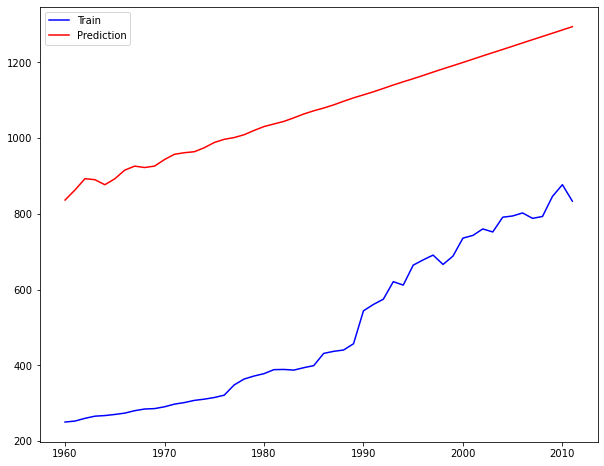

In [26]:
train_x = train['year']
train_y = train['oil_energy_use']
train_pred_x = train['year']
train_pred_y = train['ARIMA']

plt.figure(figsize = (10, 8))
plt.plot(train_x, train_y, 'blue',
         train_pred_x, train_pred_y, 'red')
plt.legend(['Train', 'Prediction'])
plt.show

In [13]:
test['ARIMA'] = arima_model.predict(len(test))
print(test)

    year  oil_energy_use       ARIMA
51  2011          833.56  836.486887
52  2012          853.21  863.186191
53  2013          863.82  892.874624
54  2014          883.77  890.231167
55  2015          900.86  876.910943
56  2016          903.97  892.575272
57  2017          917.69  915.520603
58  2018          936.89  926.074616
59  2019          940.04  922.373717
60  2020          967.33  926.177959


C:\Users\Adityas Regita P\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<function matplotlib.pyplot.show(close=None, block=None)>

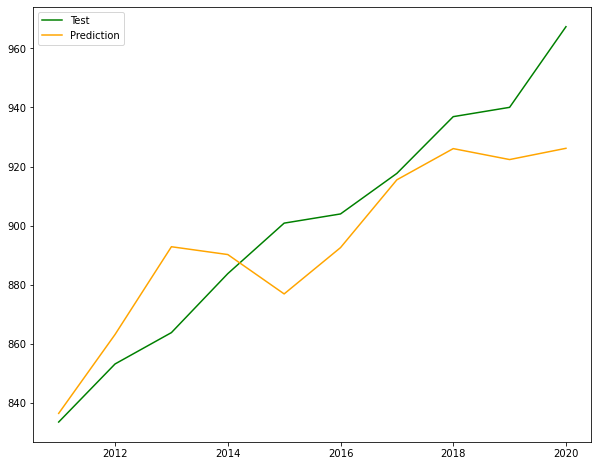

In [19]:
test_x = test['year']
test_y = test['oil_energy_use']
test_pred_x = test['year']
test_pred_y = test['ARIMA']

plt.figure(figsize = (10, 8))
plt.plot(test_x, test_y, 'green',
         test_pred_x, test_pred_y, 'orange')
plt.legend(['Test', 'Prediction'])
plt.show

In [15]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [16]:
def rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    
    return rmse

In [28]:
train_mape = mape(train.oil_energy_use, train.ARIMA)
train_rmse = rmse(train.oil_energy_use, train.ARIMA)
print('MAPE of Test Data: ', train_mape)
print('RMSE of Test Data: ', train_rmse)

MAPE of Test Data:  144.7625415619486
RMSE of Test Data:  585.1597643925651


In [17]:
test_mape = mape(test.oil_energy_use, test.ARIMA)
test_rmse = rmse(test.oil_energy_use, test.ARIMA)
print('MAPE of Test Data: ', test_mape)
print('RMSE of Test Data: ', test_rmse)

MAPE of Test Data:  1.7058257365002458
RMSE of Test Data:  19.556770958458124
